In [1]:
import numpy as np
import pandas as pd
import os.path as op
import os
from os import walk
import datetime
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(42)
tb = SummaryWriter()

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}

In [2]:
year = 2017
images = np.memmap(
    op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"),
    dtype=np.uint8,
    mode="r",
).reshape((-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))

In [3]:
label_df = pd.read_feather(
    op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")
)
assert len(label_df) == len(images)
label_df.head()

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,2017-01-31,10001,133078.0,4.370390e-07,-0.000002,-0.005954,-0.000002,0.000450
1,2017-02-28,10001,133078.0,3.951997e-03,0.002795,0.009953,0.009953,0.000180
2,2017-03-31,10001,133604.0,-7.874612e-03,-0.015749,0.021723,-0.015749,0.000064
3,2017-04-28,10001,131500.0,9.999880e-03,0.016001,0.038072,0.016001,0.000030
4,2017-05-31,10001,133604.0,4.370390e-07,0.021722,NaN,0.023703,0.000015


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                1,
                64,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                64,
                128,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(
                128,
                256,
                kernel_size=(5, 3),
                stride=(3, 1),
                dilation=(2, 1),
                padding=(12, 1),
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.reshape(-1, 1, 64, 60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1, 46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [5]:
x = torch.Tensor(images[42].copy())
x = x.reshape(-1, 1, 64, 60)
x.requires_grad = True
baseline = torch.zeros_like(x)

0


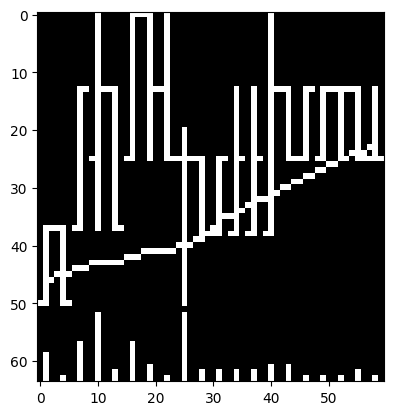

1


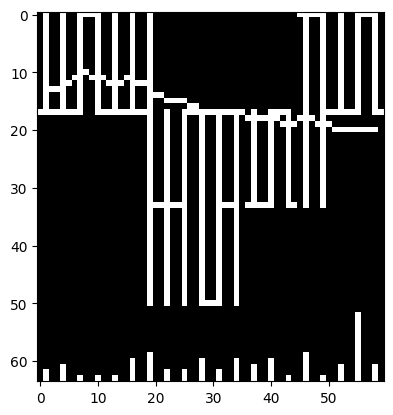

2


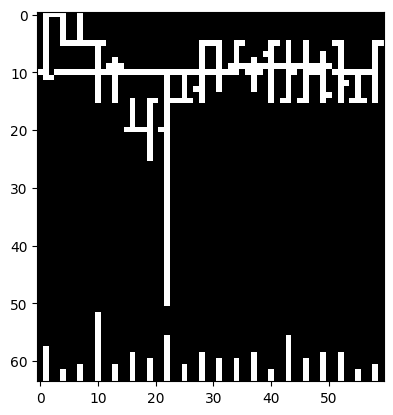

3


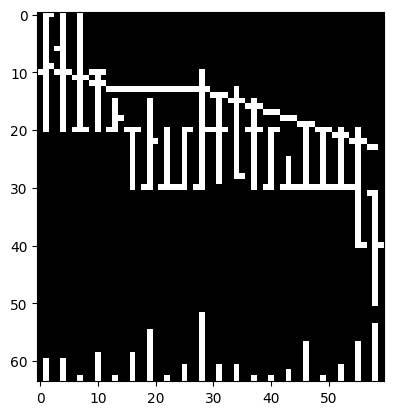

4


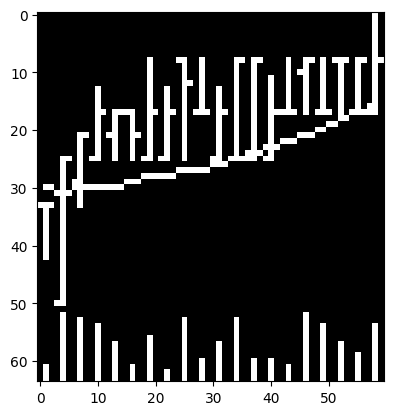

In [6]:
import matplotlib.pyplot as plt

for i in range(5):
    print(i)
    plt.imshow(images[i], cmap="gray")
    plt.show()

In [7]:
label_df.head()

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,2017-01-31,10001,133078.0,4.370390e-07,-0.000002,-0.005954,-0.000002,0.000450
1,2017-02-28,10001,133078.0,3.951997e-03,0.002795,0.009953,0.009953,0.000180
2,2017-03-31,10001,133604.0,-7.874612e-03,-0.015749,0.021723,-0.015749,0.000064
3,2017-04-28,10001,131500.0,9.999880e-03,0.016001,0.038072,0.016001,0.000030
4,2017-05-31,10001,133604.0,4.370390e-07,0.021722,NaN,0.023703,0.000015


In [8]:
year_list = np.arange(1993, 2014, 1)

images = []
label_df = []
for year in year_list:
    images.append(
        np.memmap(
            op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"),
            dtype=np.uint8,
            mode="r",
        ).reshape((-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    )
    label_df.append(
        pd.read_feather(
            op.join(
                "./monthly_20d",
                f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather",
            )
        )
    )

images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

(1787748, 64, 60)
(1787748, 8)


In [9]:
class MyDataset(Dataset):

    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

In [10]:
use_gpu = True
use_random_split = False
use_dataparallel = True

if not use_random_split:
    train_val_ratio = 0.7
    split_idx = int(images.shape[0] * 0.7)
    train_dataset = MyDataset(
        images[:split_idx], (label_df.Ret_5d > 0).values[:split_idx]
    )
    val_dataset = MyDataset(
        images[split_idx:], (label_df.Ret_5d > 0).values[split_idx:]
    )
else:
    dataset = MyDataset(images, (label_df.Ret_5d > 0).values)
    train_val_ratio = 0.7
    train_dataset, val_dataset = random_split(
        dataset,
        [
            int(dataset.len * train_val_ratio),
            dataset.len - int(dataset.len * train_val_ratio),
        ],
        generator=torch.Generator().manual_seed(42),
    )
    del dataset

train_dataloader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, pin_memory=True)

In [11]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [12]:
device = "cuda" if use_gpu else "cpu"
export_onnx = True
net = Net().to(device)
net.apply(init_weights)

if export_onnx:
    import torch.onnx

    x = torch.randn([1, 1, 64, 60]).to(device)
    torch.onnx.export(
        net,  
        x,  
        "./cnn_baseline.onnx",  
        export_params=False,  
        opset_version=10,  
        do_constant_folding=False,  
        input_names=["input_images"],  
        output_names=["output_prob"],  
        dynamic_axes={
            "input_images": {0: "batch_size"},  
            "output_prob": {0: "batch_size"},
        },
    )

In [13]:
count = 0
for names, parameters in net.named_parameters():
    print(names, parameters.size())
    count += parameters.numel()
print("total_parameters: {}".format(count))

layer1.0.weight torch.Size([64, 1, 5, 3])
layer1.0.bias torch.Size([64])
layer1.1.weight torch.Size([64])
layer1.1.bias torch.Size([64])
layer2.0.weight torch.Size([128, 64, 5, 3])
layer2.0.bias torch.Size([128])
layer2.1.weight torch.Size([128])
layer2.1.bias torch.Size([128])
layer3.0.weight torch.Size([256, 128, 5, 3])
layer3.0.bias torch.Size([256])
layer3.1.weight torch.Size([256])
layer3.1.bias torch.Size([256])
fc1.1.weight torch.Size([2, 46080])
fc1.1.bias torch.Size([2])
total_parameters: 708866


In [14]:
def train_loop(dataloader, net, loss_fn, optimizer):

    running_loss = 0.0
    current = 0
    net.train()

    with tqdm(dataloader) as t:
        for batch, (X, y) in enumerate(t):
            X = X.to(device)
            y = y.to(device)
            y_pred = net(X)
            loss = loss_fn(y_pred, y.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss = (len(X) * loss.item() + running_loss * current) / (
                len(X) + current
            )
            current += len(X)
            t.set_postfix({"running_loss": running_loss})

    return running_loss

In [15]:
def val_loop(dataloader, net, loss_fn):
    running_loss = 0.0
    current = 0
    net.eval()

    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                loss = loss_fn(y_pred, y.long())

                running_loss += loss.item()
                running_loss = (len(X) * running_loss + loss.item() * current) / (
                    len(X) + current
                )
                current += len(X)
                t.set_postfix({"running_loss": running_loss})

    return running_loss

In [16]:
if use_gpu and use_dataparallel and "DataParallel" not in str(type(net)):
    net = net.to(device)
    net = nn.DataParallel(net)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)

start_epoch = 0
min_val_loss = 1e9
last_min_ind = -1
early_stopping_epoch = 5

Epoch 0
-------------------------------


100%|██████████| 4191/4191 [00:21<00:00, 195.66it/s, running_loss=0.661]


Epoch 1
-------------------------------


100%|██████████| 4191/4191 [00:20<00:00, 201.20it/s, running_loss=0.653]


Epoch 2
-------------------------------


100%|██████████| 4191/4191 [00:20<00:00, 200.21it/s, running_loss=0.733]


Epoch 3
-------------------------------


100%|██████████| 4191/4191 [00:21<00:00, 199.51it/s, running_loss=0.611]


Epoch 4
-------------------------------


100%|██████████| 4191/4191 [00:21<00:00, 199.19it/s, running_loss=0.71] 


Epoch 5
-------------------------------


100%|██████████| 4191/4191 [00:20<00:00, 202.39it/s, running_loss=0.698]


Epoch 6
-------------------------------


100%|██████████| 4191/4191 [00:20<00:00, 201.36it/s, running_loss=0.811]


Epoch 7
-------------------------------


100%|██████████| 4191/4191 [00:20<00:00, 203.12it/s, running_loss=0.818]


Epoch 8
-------------------------------


100%|██████████| 4191/4191 [00:21<00:00, 199.11it/s, running_loss=0.831]


Done!
Best epoch: 3, val_loss: 0.611354069716394


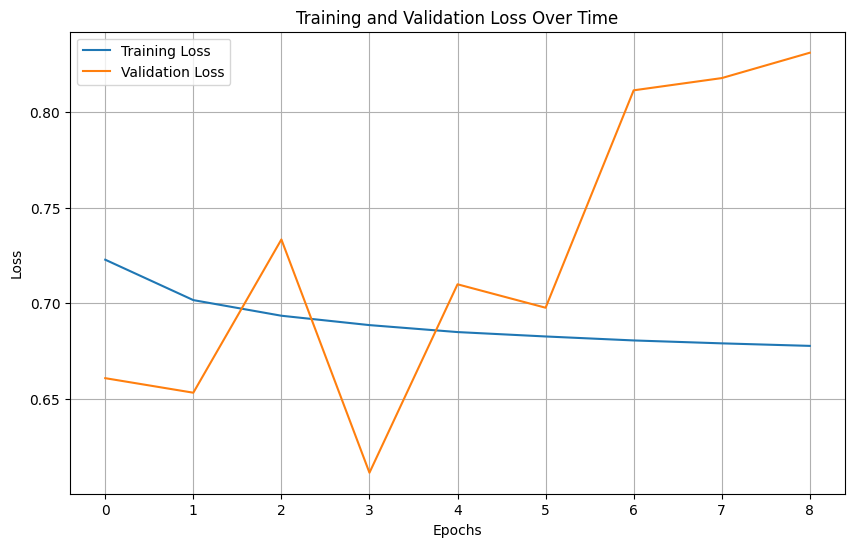

In [18]:
train_losses = []
val_losses = []

start_time = datetime.datetime.now().strftime("%Y%m%d_%H:%M:%S")
directory_path = "./pt/{}".format(start_time.replace(":", "-"))
os.makedirs(directory_path)

epochs = 100
for t in range(start_epoch, epochs):
    print(f"Epoch {t}\n-------------------------------")
    time.sleep(0.2)
    train_loss = train_loop(train_dataloader, net, loss_fn, optimizer)
    val_loss = val_loop(val_dataloader, net, loss_fn)

    # Append the losses to our tracking list
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    tb.add_histogram("train_loss", train_loss, t)
    torch.save(
        net,
        "./pt"
        + os.sep
        + start_time.replace(":", "-")
        + os.sep
        + "baseline_epoch_{}_train_{:5f}_val_{:5f}.pt".format(t, train_loss, val_loss),
    )
    if val_loss < min_val_loss:
        last_min_ind = t
        min_val_loss = val_loss
        min_val_loss_path = './pt/{}'.format(start_time.replace(":", "-"))
    elif t - last_min_ind >= early_stopping_epoch:
        break

print("Done!")
print("Best epoch: {}, val_loss: {}".format(last_min_ind, min_val_loss))

# Add this after the training loop to create the visualization
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.savefig(f"{directory_path}/loss_curve.png")  # Save the figure to the same directory as model checkpoints
plt.show()

## Testing

In [ ]:
year_list = np.arange(2015, 2019, 1)

images = []
label_df = []

for year in year_list:
    images.append(
        np.memmap(
            op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"),
            dtype=np.uint8,
            mode="r",
        ).reshape((-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    )
    label_df.append(
        pd.read_feather(
            op.join(
                "./monthly_20d",
                f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather",
            )
        )
    )

images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

In [19]:
dataset = MyDataset(images, (label_df.Ret_5d > 0).values)
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

In [20]:
net_path = 'pt/20250320_23-47-53/baseline_epoch_3_train_0.688597_val_0.611354.pt'
net = torch.load(net_path, weights_only=False)


In [21]:
def eval_loop(dataloader, net, loss_fn):
    
    running_loss = 0.0
    total_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'running_loss':running_loss})
            
    return total_loss, torch.cat(predict), torch.cat(target)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:,1]).cpu().numpy()

In [ ]:
# Calculate the percentage of target predicted above 0.5
predictions = (predict_logit > 0.5).sum()
total = len(predict_logit)
accuracy = (predictions / total) * 100

print(f"Test Accuracy: {accuracy:.2f}%")


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

# Convert predictions to binary
binary_predictions = (predict_logit > 0.5).astype(int)
binary_targets = y_target.cpu().numpy()

# Calculate F1 score, recall, and precision
f1 = f1_score(binary_targets, binary_predictions)
recall = recall_score(binary_targets, binary_predictions)
precision = precision_score(binary_targets, binary_predictions)

print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
